# Preprocessing and Modeling
---

## Problem statement:
We are looking into breaking into the world of freelance data journalism and are reaching out to Nate Silver and co. at FiveThirtyEight so they can hear our pitch on how to create a Reddit post that will get the most engagement. We want to find out what characteristics of a post on Reddit will be the most predictive of the overall interaction on a post as measured by number of comments (above/below the median). With this we hope to provide a classification model to FiveThirtyEight that is satisfactory and jumpstart our career!

## Let's add all the necessary imports here
---

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     cross_val_predict, StratifiedKFold, GridSearchCV)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier

import re
import random
# method found on https://www.educative.io/edpresso/how-to-remove-emoji-from-the-text-in-python
from cleantext import clean

import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from nltk.stem.porter import *
from nltk.stem import PorterStemmer

plt.style.use('ggplot')

In [2]:
random.seed(42)

## Now let's read in our csv file and clean the `title` column of any weird text
---

In [3]:
df = pd.read_csv('../data/cleaned_df.csv')
df.head()

,subreddit,title,number_of_comments,time_difference
0,facepalm,Show me,1413,210
1,WhitePeopleTwitter,Her name was Michelle Snow and she was almost 8,577,230
2,movies,"Dear god, no, Morbius 2 has not been greenlit",1001,207
3,funny,So Costco apparently doesn't re-take membershi...,792,349
4,oddlysatisfying,How to draw balls,416,164


In [4]:
df.subreddit.value_counts(normalize=True)

memes              0.001804
Superstonk         0.001804
shitposting        0.001698
formuladank        0.001645
worldnews          0.001645
                     ...   
JhinMains          0.000053
Satan              0.000053
CasualIreland      0.000053
dogswearinghats    0.000053
Habs               0.000053
Name: subreddit, Length: 3810, dtype: float64

### Let's remove anything inside brackets or parenthesis.

In [5]:
df['title'] = [re.sub('[\*\(\[].*?[\)\]\*]', '', title.replace('\n', '')) for title in df['title']]

### Let's remove any emojis as well.

In [6]:
# clean function found on https://www.educative.io/edpresso/how-to-remove-emoji-from-the-text-in-python
# and here https://pypi.org/project/clean-text/
df['title'] = [clean(title, no_emoji=True) for title in df['title']]

In [7]:
df['title'] = [clean(title, no_line_breaks=True, no_urls=True, no_emails=True, no_numbers=True, no_phone_numbers=True, 
                     no_currency_symbols=True, no_punct=True) for title in df['title']]

## Now convert our title data into matrix representation using `TfidfVectorizer`
---

In [8]:
tvec = TfidfVectorizer(stop_words='english', 
                       strip_accents='ascii',
                       max_features=200, 
                       norm='l2', )
tvec.fit(df['title'])

TfidfVectorizer(max_features=200, stop_words='english', strip_accents='ascii')

In [9]:
df_tvec = pd.DataFrame(tvec.transform(df['title']).todense(), 
                       columns=tvec.get_feature_names())

# add target variable, 1 - at or above median num comments
# 0 - below median num comments
df_tvec['target_var'] = (df['number_of_comments'] >= df['number_of_comments'].median()).astype(int)

print(df_tvec.shape)
df_tvec.head()

(18845, 201)


,actually,ago,american,art,away,baby,bad,beautiful,best,better,...,women,work,working,world,wrong,year,years,yesterday,youre,target_var
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


## Now let's create custom columns for our `subreddit` column, "appears in top 20" and "appears more than once", and join that column with time_difference to our df_tvec.
---

In [10]:
df_dum = pd.get_dummies(df['subreddit'],prefix='subreddit')

# filter out subreddits that show up more than once!
dummy_filter = [col for col in df_dum.columns if df_dum[col].sum() > 1]

In [11]:
more_than_once_filter = [col.replace('subreddit_', '') for col in dummy_filter]

In [12]:
df.head(2)

,subreddit,title,number_of_comments,time_difference
0,facepalm,show me,1413,210
1,WhitePeopleTwitter,her name was michelle snow and she was almost ...,577,230


In [13]:
df['subreddit_appears_more_than_once'] = [1 if sub in more_than_once_filter else 0 for sub in  df['subreddit']]

In [14]:
df.head(3)

,subreddit,title,number_of_comments,time_difference,subreddit_appears_more_than_once
0,facepalm,show me,1413,210,1
1,WhitePeopleTwitter,her name was michelle snow and she was almost ...,577,230,1
2,movies,dear god no morbius <number> has not been gree...,1001,207,1


In [15]:
df_dum = pd.get_dummies(df['subreddit'],prefix='subreddit')

# filter out subreddits that show up more than 30 times (equals to top 10 occuring)
dummy_filter = [col for col in df_dum.columns if df_dum[col].sum() >= 30]

In [16]:
Top_10_filter = [col.replace('subreddit_', '') for col in dummy_filter]

In [17]:
Top_10_filter

['MadeMeSmile',
 'Superstonk',
 'Unexpected',
 'WhitePeopleTwitter',
 'dankmemes',
 'formula1',
 'formuladank',
 'memes',
 'shitposting',
 'worldnews']

In [18]:
df['subreddit_in_top_10'] = [1 if sub in Top_10_filter else 0 for sub in  df['subreddit']]

In [19]:
df.head()

,subreddit,title,number_of_comments,time_difference,subreddit_appears_more_than_once,subreddit_in_top_10
0,facepalm,show me,1413,210,1,0
1,WhitePeopleTwitter,her name was michelle snow and she was almost ...,577,230,1,1
2,movies,dear god no morbius <number> has not been gree...,1001,207,1,0
3,funny,so costco apparently doesnt retake membership ...,792,349,1,0
4,oddlysatisfying,how to draw balls,416,164,1,0


In [20]:
df_tvec = df_tvec.join(df.drop(columns=['subreddit', 'title','number_of_comments']))

In [21]:
df_tvec.head()

,actually,ago,american,art,away,baby,bad,beautiful,best,better,...,world,wrong,year,years,yesterday,youre,target_var,time_difference,subreddit_appears_more_than_once,subreddit_in_top_10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,210,1,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,230,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,207,1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,349,1,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,164,1,0


### Let's calculate our baseline from our `target_var` variable

In [22]:
df_tvec['target_var'].value_counts(normalize=True)

1    0.500292
0    0.499708
Name: target_var, dtype: float64

### This means that our baseline (class majority) is that a post is 50% like to be above the median number of comments.

## Let's create a function to print out the scores for us.

In [23]:
def model_scores(cv_scores, model, X, y):  
    print(f'Score from knn: {model.score(X, y):.4f}')
    print(f'Min and Max scores are: [{cv_scores.min():.4f}, {cv_scores.max():.4f}]')
    print(f'Confidence interval is : {cv_scores.mean():.4f} \u00B1 {2*cv_scores.std():.4f}')

## Now let's run a KNN model using cross_val_score to see how well our model does against our baseline.
---

In [24]:
X = df_tvec.drop('target_var', axis=1)
y = df_tvec.target_var

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)

X_test_ss = ss.transform(X_test)

In [26]:
%%time
knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=10)

knn.fit(X_train_ss, y_train)

knn.score(X_test_ss, y_test)

# https://stackoverflow.com/questions/44446501/how-to-standardize-data-with-sklearns-cross-val-score
# pipeline idea from above^
pipeline = Pipeline([('standard_scale', ss), ('knn', knn)])

scores = cross_val_score(pipeline, X, y, n_jobs=-1)
model_scores(scores, knn, X_test_ss, y_test)

Score from knn: 0.5986
Min and Max scores are: [0.5805, 0.6041]
Confidence interval is : 0.5945 ± 0.0208
Wall time: 7.97 s


### For our knn model we got an accuracy score of 59.86% which is a 9% improvement over our baseline score of 50%. We also have a confidence interval that tells us we are 95% confident that the true accuracy lies within 0.5945 ± 0.0208. For this model we had the following parameters
- max vectorized features of 200
- 2 dummy subreddit columns (subreddits that showed up more than once and if subreddit in top 10)
- time_difference column
- all features standard scaled
- all post titles cleaned

## Now let's try stemming our text and see how that changes our model
---

In [27]:
nlp = spacy.load('en_core_web_sm')

In [28]:
stemmer = PorterStemmer()

In [29]:
%%time
df['stemmed_title'] = [ ' '.join([stemmer.stem(word.text) for word in nlp(title)]) for title in df.title]

Wall time: 1min 22s


In [30]:
df.head(3)

,subreddit,title,number_of_comments,time_difference,subreddit_appears_more_than_once,subreddit_in_top_10,stemmed_title
0,facepalm,show me,1413,210,1,0,show me
1,WhitePeopleTwitter,her name was michelle snow and she was almost ...,577,230,1,1,her name wa michel snow and she wa almost < nu...
2,movies,dear god no morbius <number> has not been gree...,1001,207,1,0,dear god no morbiu < number > ha not been gree...


### Now convert our stemmed_title data into matrix representation using `TfidfVectorizer`

In [31]:
tvec2 = TfidfVectorizer(stop_words='english', 
                       strip_accents='ascii',
                       max_features=200, 
                       norm='l2')
tvec2.fit(df['stemmed_title'])

TfidfVectorizer(max_features=200, stop_words='english', strip_accents='ascii')

In [32]:
df_tvec2 = pd.DataFrame(tvec2.transform(df['stemmed_title']).todense(), 
                       columns=tvec2.get_feature_names())

# add target variable, 1 - at or above median num comments
# 0 - below median num comments
df_tvec2['target_var'] = (df['number_of_comments'] >= df['number_of_comments'].median()).astype(int)

print(df_tvec2.shape)
df_tvec2.head()

(18845, 201)


,absolut,actual,ago,alway,american,ani,anim,anoth,anyon,art,...,week,went,whi,win,women,work,world,year,yesterday,target_var
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Concatenate necessary columns to create final df_tvec2

In [33]:
df_tvec2 = df_tvec2.join(df.drop(columns=['title','number_of_comments', 'subreddit', 'stemmed_title']))

In [34]:
df_tvec2

,absolut,actual,ago,alway,american,ani,anim,anoth,anyon,art,...,win,women,work,world,year,yesterday,target_var,time_difference,subreddit_appears_more_than_once,subreddit_in_top_10
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,210,1,0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,230,1,1
2,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,207,1,0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,349,1,0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,164,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18840,0.0,0.0,0.0,0.650935,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,726,1,0
18841,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.766434,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,309,1,0
18842,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,478,1,0
18843,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,794,1,0


## Let's run a KNN model again, with our stemmed text, using cross_val_score to see how well our model does against our baseline.
---

In [35]:
X = df_tvec2.drop('target_var', axis=1)
y = df_tvec2.target_var

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)

X_test_ss = ss.transform(X_test)

In [37]:
%%time
knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=10)

knn.fit(X_train_ss, y_train)

knn.score(X_test_ss, y_test)

# https://stackoverflow.com/questions/44446501/how-to-standardize-data-with-sklearns-cross-val-score
# pipeline idea from above^
pipeline = Pipeline([('standard_scale', ss), ('knn', knn)])

scores = cross_val_score(pipeline, X, y, n_jobs=-1)

model_scores(scores, knn, X_test_ss, y_test)

Score from knn: 0.6004
Min and Max scores are: [0.5665, 0.6089]
Confidence interval is : 0.5916 ± 0.0347
Wall time: 7.53 s


### For our knn model we got an accuracy score of 60.04% which is a 10% improvement over our baseline score of 50% and a 0.18% increase over our KNN model without stemmed words. We also have a confidence interval that tells us we are 95% confident that the true accuracy lies within 0.5916 ± 0.0347. Interesting to note that our mean score went down by 0.3% and our confidence interval widened by 1%. For this model we had the following parameters

- max vectorized features of 200
- 2 dummy subreddit columns (subreddits that showed up more than once and if subreddit in top 10)
- time_difference column
- all features standard scaled
- all post titles cleaned and stemmed


## Now let's try lemmatizing our text and see how that changes our model
---

In [38]:
%%time
df['lemmatized_title'] = [ ' '.join([word.lemma_ for word in nlp(title)]) for title in df.title]

Wall time: 1min 15s


In [39]:
df.head(3)

,subreddit,title,number_of_comments,time_difference,subreddit_appears_more_than_once,subreddit_in_top_10,stemmed_title,lemmatized_title
0,facepalm,show me,1413,210,1,0,show me,show I
1,WhitePeopleTwitter,her name was michelle snow and she was almost ...,577,230,1,1,her name wa michel snow and she wa almost < nu...,her name be michelle snow and she be almost < ...
2,movies,dear god no morbius <number> has not been gree...,1001,207,1,0,dear god no morbiu < number > ha not been gree...,dear god no morbius < number > have not be gre...


### Now convert our lemmatized_title data into matrix representation using `TfidfVectorizer`

In [40]:
tvec3 = TfidfVectorizer(stop_words='english', 
                       strip_accents='ascii',
                       max_features=200, 
                       norm='l2')
tvec3.fit(df['lemmatized_title'])

TfidfVectorizer(max_features=200, stop_words='english', strip_accents='ascii')

In [41]:
df_tvec3 = pd.DataFrame(tvec3.transform(df['stemmed_title']).todense(), 
                       columns=tvec3.get_feature_names())

# add target variable, 1 - at or above median num comments
# 0 - below median num comments
df_tvec3['target_var'] = (df['number_of_comments'] >= df['number_of_comments'].median()).astype(int)

print(df_tvec3.shape)
df_tvec3.head()

(18845, 201)


,actually,ago,american,art,ask,away,baby,bad,base,beautiful,...,week,wife,win,woman,work,world,wrong,year,yesterday,target_var
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Concatenate necessary columns to create final df_tvec3

In [42]:
df_tvec3 = df_tvec3.join(df.drop(columns=['title','number_of_comments', 'subreddit', 'stemmed_title', 'lemmatized_title']))

In [43]:
df_tvec3

,actually,ago,american,art,ask,away,baby,bad,base,beautiful,...,woman,work,world,wrong,year,yesterday,target_var,time_difference,subreddit_appears_more_than_once,subreddit_in_top_10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,210,1,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,230,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,207,1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,349,1,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,164,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,726,1,0
18841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,309,1,0
18842,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,478,1,0
18843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,794,1,0


## Let's run a KNN model again, with our lemmatized text, using cross_val_score to see how well our model does against our baseline.
---

In [44]:
X = df_tvec3.drop('target_var', axis=1)
y = df_tvec3.target_var

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
ss = StandardScaler()

X_train_ss = ss.fit_transform(X_train)

X_test_ss = ss.transform(X_test)

In [46]:
%%time
knn = KNeighborsClassifier(n_jobs=-1, n_neighbors=10)

knn.fit(X_train_ss, y_train)

knn.score(X_test_ss, y_test)

# https://stackoverflow.com/questions/44446501/how-to-standardize-data-with-sklearns-cross-val-score
# pipeline idea from above^
pipeline = Pipeline([('standard_scale', ss), ('knn', knn)])

scores = cross_val_score(pipeline, X, y, n_jobs=-1)

model_scores(scores, knn, X_test_ss, y_test)

Score from knn: 0.6033
Min and Max scores are: [0.5826, 0.6262]
Confidence interval is : 0.6016 ± 0.0326
Wall time: 6.58 s


### For our knn model we got an accuracy score of 60.33% which is a 10% improvement over our baseline score of 50% and a slight increase of  0.4% compared to our KNN model without stemmed words. Comparing this model to our stemmed words model we see only a 0.3% increase. We also have a confidence interval that tells us we are 95% confident that the true accuracy lies within 0.6016 ± 0.0326. Interesting to note that our mean score went up by 0.7% and our confidence interval widened by 1.2% compared to our regular unstemmed model. For this model we had the following parameters

- max vectorized features of 200
- 2 dummy subreddit columns (subreddits that showed up more than once and if subbreddit in top 10)
- time_difference column
- all features standard scaled
- all post titles cleaned and lemmatized

### This model proved to have the highest mean confidence interval with the 2nd tightest range, for this reason we will be moving forward with our lemmatized text model.

## Our best model was the one that had the titles lemmatized. Let's create a confusion matrix to see how it does with predicting if a post will be at/above the median number of comments or below the median number of comments.
---

In [47]:
predicted_cross = cross_val_predict(pipeline, X, y)

con_matrix = confusion_matrix(y, predicted_cross, labels=[1, 0])

,predicted at/above,predicted below
at/above med num_comments,4600,4828
below med num_comments,2660,6757


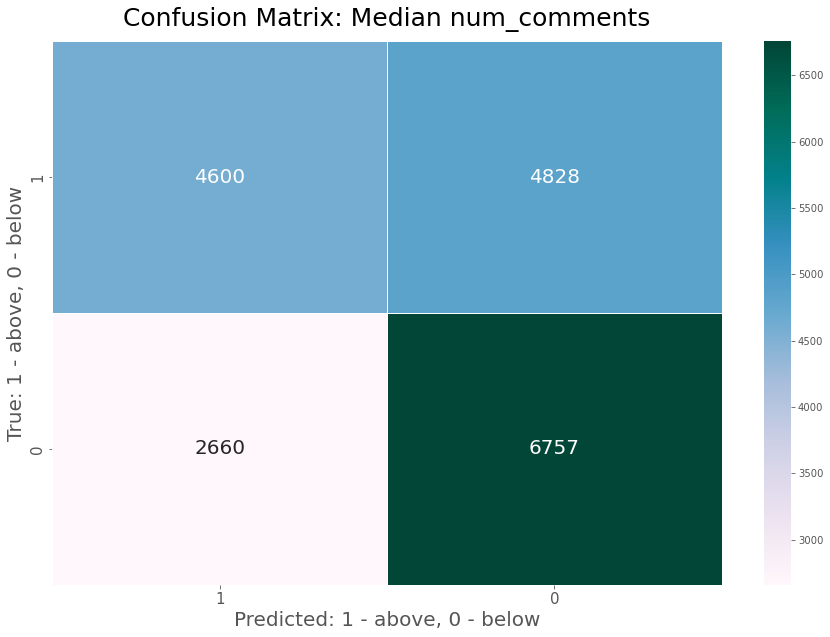

In [48]:
fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(con_matrix, annot=True, fmt='.4g', linewidths=1,\
            linecolor='white', xticklabels=[1, 0], yticklabels=[1,0], cmap='PuBuGn', annot_kws={"size": 20})

plt.title('Confusion Matrix: Median num_comments', fontsize=25, pad=15)
plt.xlabel('Predicted: 1 - above, 0 - below', fontsize=20);
plt.ylabel('True: 1 - above, 0 - below', fontsize=20);
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

pd.DataFrame(con_matrix, 
             index=['at/above med num_comments', 'below med num_comments'], 
             columns=['predicted at/above', 'predicted below'])

In [49]:
print('CLassification report for classifier\n %s' % (classification_report(y, predicted_cross, labels=[1, 0])))

CLassification report for classifier
               precision    recall  f1-score   support

           1       0.63      0.49      0.55      9428
           0       0.58      0.72      0.64      9417

    accuracy                           0.60     18845
   macro avg       0.61      0.60      0.60     18845
weighted avg       0.61      0.60      0.60     18845



### From the above confusion matrix and the classification report we can see that our lemmatized model has an accuracy of 60%. We also see that we have a higher precision for 1 - at/above median num_comments, than for 0 - below the median num_comments, at .63 and .58 respectively. This means that for our predicted 1s we mistook 37% as true 0s. On the other hand we see that we have a higher recall score for 0s than we do for 1s with .72 and .49 respectively. This means that for our true 0s 72% were correctly predicted as the right class.

## Now let's create a Random Forest Model.
---

In [50]:
X = df_tvec3.drop(columns=['target_var'], axis=1)
y = df_tvec3.target_var

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Let's use GridSearchCV to find the best parameters to use for our Random Forests

In [51]:
rf_params = {'n_estimators': range(100, 800, 100), 
             'max_depth': range(1, 17, 1), 
             'class_weight': ['balanced', 'balanced_subsample']}

In [52]:
rf_gridsearch = GridSearchCV(RandomForestClassifier(n_jobs=-1, random_state=42), 
                             rf_params,
                             cv=5,
                             verbose=1)

In [53]:
rf_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 224 candidates, totalling 1120 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'max_depth': range(1, 17),
                         'n_estimators': range(100, 800, 100)},
             verbose=1)

In [54]:
rf_gridsearch.best_params_

{'class_weight': 'balanced', 'max_depth': 16, 'n_estimators': 700}

### Using the best parameters above let's input those into our model and cross_val_score

In [55]:
%%time
rf = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=700, class_weight='balanced', max_depth=16)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

scores = cross_val_score(rf, X, y, cv=cv)

model_scores(scores, rf, X_test, y_test)

Score from knn: 0.6668
Min and Max scores are: [0.6424, 0.6663]
Confidence interval is : 0.6556 ± 0.0120
Wall time: 28.2 s


### For our random forests model we got an accuracy score of 66.68% which is a 16% improvement over our baseline score of 50%. Comparing this model to our lemmatized words model we see an increase of 6%. We also have a confidence interval that tells us we are 95% confident that the true accuracy lies within 0.6556 ± 0.0128. Interesting to note that this model has the lowest variance out of all of our previous models.  For this model we had the following parameters

- max vectorized features of 200
- 2 dummy subreddit columns (subreddits that showed up more than once and if subreddit in top 10)
- time_difference column
- all post titles cleaned and lemmatized
- best parameters from GridSearchCV

## Moving forward we will be using our random forest model. This model has the highest mean score and the lowest variance (confidence interval) out of all of our models. It also has a property called `feature_importances_` which can help us determine which features are more relevant in our model and thus helping us answer our problem statement.
---

In [56]:
%%time
predicted_cross2 = cross_val_predict(rf, X, y, cv=cv)

Wall time: 25.7 s


In [57]:
con_matrix2 = confusion_matrix(y, predicted_cross2, labels=[1, 0])

,predicted at/above,predicted below
at/above med num_comments,4600,4828
below med num_comments,2660,6757


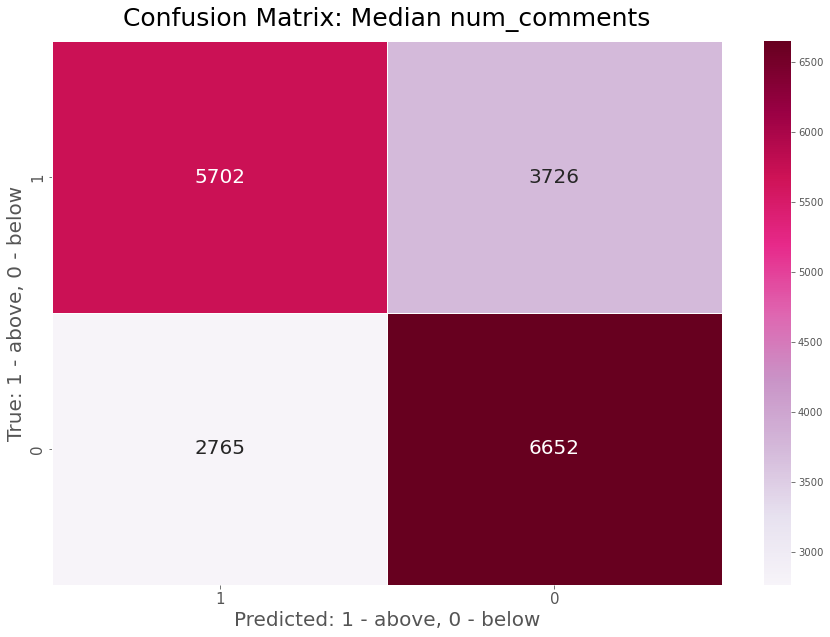

In [58]:
fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(con_matrix2, annot=True, fmt='.4g', linewidths=1,\
            linecolor='white', xticklabels=[1, 0], yticklabels=[1,0], cmap='PuRd', annot_kws={"size": 20})

plt.title('Confusion Matrix: Median num_comments', fontsize=25, pad=15)
plt.xlabel('Predicted: 1 - above, 0 - below', fontsize=20);
plt.ylabel('True: 1 - above, 0 - below', fontsize=20);
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

pd.DataFrame(con_matrix, 
             index=['at/above med num_comments', 'below med num_comments'], 
             columns=['predicted at/above', 'predicted below'])

In [59]:
print('CLassification report for classifier\n %s' % (classification_report(y, predicted_cross2, labels=[1, 0])))

CLassification report for classifier
               precision    recall  f1-score   support

           1       0.67      0.60      0.64      9428
           0       0.64      0.71      0.67      9417

    accuracy                           0.66     18845
   macro avg       0.66      0.66      0.65     18845
weighted avg       0.66      0.66      0.65     18845



### From the above confusion matrix and the classification report we can see that our random forest model has an accuracy of 66%. We also see that we have a higher precision for 1 - at/above median num_comments, than for 0 - below the median num_comments, at .67 and .64 respectively. This means that for our predicted 1s we mistook 37% as true 0s. On the other hand we see that we have a higher recall score for 0s than we do for 1s with .71 and .60 respectively. This means that for our true 0s 71% were correctly predicted as the right class.

## Now let's take a look at the `feature_importances_` to see what features our random forest model deemed more important.

In [60]:
df_feature_importance = pd.DataFrame({'feature':df_tvec3.drop('target_var', axis=1).columns,
                                      'importance':rf.feature_importances_})
df_feature_importance.sort_values('importance', ascending=False).head(5)

,feature,importance
200,time_difference,0.466136
201,subreddit_appears_more_than_once,0.103166
202,subreddit_in_top_10,0.056438
121,number,0.019188
198,year,0.013063


### According to our Random Forests model, the top 5 features with the best predictive power / importance are 
- 'time_difference' 
- 'subreddit_appears_more_than_once'
- 'subreddit_in_top_10'
- 'number'
- 'year'

### Let's take a closer look at time_difference.

In [61]:
df_tvec3.groupby('target_var').describe()['time_difference']

,count,mean,std,min,25%,50%,75%,max
target_var,,,,,,,,
0,9417.0,395.213762,218.911516,26.0,231.0,347.0,517.0,1383.0
1,9428.0,578.105218,292.588964,16.0,342.0,536.0,789.0,1439.0


### We can see from the descriptive statistics above that for hot posts the average time difference (post age) is around 578 minutes or around 10 hours while for not hot it is 395 minutes or around 7 hours. We also see that the 50% of posts that are hot are above 500 minutes while only 25% of posts that are not are at above 500 minutes. This shows that posts that are hot take time to get engagement.

## Executive Summary
FiveThirtyEight has made its name known as a leader in data journalism. From politics to sports blogging, the talent at FiveThirtyEight is outstanding and it is my pleasure to pitch my idea of a Reddit post classifier. Reddit is a very popular social media site and we are striving to identify the characteristics that make a high interaction post. We will build a classification model that will help us identify the most predictive characteristics of a high interaction post.

At FiveThirtyEight the mission statement, We use data and evidence to advance public knowledge — adding certainty where we can and uncertainty where we must, truly embodies what data journalism should be. Whether you are a fan of Reddit or not, it is hard to ignore that the site has 48 million active monthly users. Being able to create a post with high interaction is a great way to get information out to a massive audience. What better way to advance public knowledge than through public awareness.

In order to create our classification model, we will be web scraping using the Reddit API PRAW. From here we will clean our data of any missing values and any duplicates. Once we have all our data scraped and cleaned then we can move on to preprocessing our features. Once our data is processed to our liking we can move on and start testing different classification models, shooting for a model that produces the highest accuracy with interpretable results.

As a recent graduate of General Assembly, I have gained the experience necessary to undertake such a task. I am familiar with the skills needed and have completed prior projects that showcase a high aptitude to perform. I am also genuinely interested in our problem at hand and I believe that to be a foundational aspect to performing good work, I am sure those at FiveThirtyEight can agree.

The opportunity to work with an entity such as FiveThirtyEight is a dream come true. The mission that they strive for is something that I truly resonate with. We will create a model that can accurately classify a “hot” post and identify the characteristics of a high interaction post. With this, we can help advance public knowledge and spread awareness of different topics to a giant user base. Let’s create this model and help further FiveThirtyEight’s mission.

## Conclusions and recommendations
---

We were tasked with creating a classification model to find out what characteristics of a post on Reddit will be the most predictive of the overall interaction on a post as measured by number of comments (above/below the median). Our best model, Random Forest, produced an accuracy score of 66.68%, which is 16.68% better than our baseline. Our model also produced feature importance which allowed us to identify the top 5 features to craft a Reddit post that will have better odds of increased overall interaction.

Our model identified the folloowing 5 features as the most important: time_difference, subreddit_appears_more_than_once, subreddit_in_top_10, number, and year. The feature time_difference, or post age, is the only continuous variable so further exploration was necessary. We discovered that for our "hot" (above the median number of comments) posts the average post age was 578 minutes or roughly 10 hours. We also saw that for our "not-hot" (below the median number of comments) posts the average post age was 395 minutes or roughly 7 hours. We can gauge that when writing a post it takes time to get engagement but if our post is not "hot" after 10 hours we may want to reconsider our post. For the following 2 features, subreddit_appears_more_than_once and subreddit_in_top_10, number, we want our post to be from a subreddit that appears more than once in "hot" and in our top 10 list. The last 2 features, number and year, are tokens/words that appeared in our posts. Number is a tokenized word for any post that contained numbers so we want to make sure that our post has numbers in it to better increase our chances of a high interaction post. If possible we also want to include the word "year", potentially stating what year we are in or a past/future year, again to better increase our chances of a high interaction post.

We believe that our finding can benefit those at FiveThirtyEight but we do recommend a substantial amount of additional data be collected to better improve our model. Reddit has about 48 million active monthly users so new posts are made constantly. To create a better model we should collect data at certain day/time intervals as well to see if there is any relationship as to what day a post was made and post interaction. Collecting additional post attributes is also recommended, there may be additional attributes that our model can use to show potentially better predictive power than the features that were collected.